In [39]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as sp
import matplotlib.pyplot as plt
import json
import logging
import warnings
import os
import shutil 
import subprocess
import time

warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)


# Function to get the current git tag
def get_git_tag():
        try:
            tag = subprocess.check_output(["git", "describe", "--tags"], stderr=subprocess.DEVNULL).strip().decode()
            return tag
        except subprocess.CalledProcessError:
            return "No tag found"


def generate_iid_samples(component_types, component_params, num_samples=2000, weights=None, rng=None):
    """
    Generate IID samples from a mixture distribution.

    Parameters:
    - component_types: List of strings specifying the type of each component (e.g., ["normal", "beta"]).
    - component_params: List of dictionaries with parameters for each component.
    - num_samples: Number of samples to generate.
    - weights: List of weights for the components.
    - rng: Random number generator.

    Returns:
    - iid_samples: Array of generated IID samples.
    """

    rng = rng or np.random.default_rng()

    if len(component_types) != len(component_params):
        raise ValueError("Each component type must have a corresponding parameter dictionary.")

    # Default: Uniform weights if not provided
    if weights is None:
        weights = np.ones(len(component_types)) / len(component_types)
    else:
        weights = np.array(weights) / np.sum(weights)

    # Choose which component each sample belongs to based on weights
    chosen_components = rng.choice(len(component_types), size=num_samples, p=weights)

    # Mapping from string names to scipy sampling functions
    scipy_distributions = {
        
        "normal": sp.norm.rvs,
        "student_t": sp.t.rvs,
        "beta": sp.beta.rvs,
        "cauchy": sp.cauchy.rvs,
        "laplace": sp.laplace.rvs,
        "mv_normal": sp.multivariate_normal.rvs
    }

    # Determine if we are in a multivariate setting
    is_mv_normal = component_types[0] == "mv_normal"
    if is_mv_normal:
        first_mv_dim = len(component_params[0]["mu"])
        iid_samples = np.empty((num_samples, first_mv_dim))  # Multivariate case
    else:
        iid_samples = np.empty(num_samples)  # Univariate case


    for i, (comp_type, comp_params) in enumerate(zip(component_types, component_params)):
        mask = chosen_components == i  # Select samples for this component
        num_selected = mask.sum()
        if num_selected > 0:
            if comp_type in scipy_distributions:
                iid_samples[mask] = scipy_distributions[comp_type](*list(comp_params.values()), size=num_selected, random_state=rng)  # need to fix .values()
            else:
                raise ValueError(f"Unsupported component type in IID sampling: {comp_type}")

    return iid_samples


def generate_mvnormal_samples(mu, cov, num_samples=2000, rng=None):
    """
    Generate IID samples from a multivariate normal distribution.
    """
    rng = rng or np.random.default_rng()
    return rng.multivariate_normal(mean=np.array(mu), cov=np.array(cov), size=num_samples)

# needs to be adapted 
def get_initvals(init_scheme, means, num_chains, rng=None):
    """Generates initialization values based on the chosen scheme."""

    middle_point = sum(means) / 2

    if init_scheme == "half_per_mode":
        # Half the chains start near the first mode, half near the second mode
        if init_scheme == "half_per_mode":
            # Dynamically assign half the chains to means[0] and the other half to means[1]
            initvals = [{"w": 0.5, "mixed_normal": means[i < num_chains // 2]} for i in range(num_chains)]

           # initvals = [
            #{"mixed_normal": 0},  # Chain 1
            #{"mixed_normal": 0},  # Chain 2
            #{"mixed_normal": 20},  # Chain 3
            #{"mixed_normal": 20}   # Chain 4
        #]

    elif init_scheme == "one_third_first_mode":
        # 🔹 1/3 of chains start in first mode, 2/3 in second mode
        num_first_mode = num_chains // 3  # 1/3 of chains
        num_second_mode = num_chains - num_first_mode  # Remaining 2/3

        initvals = (
            [{"mixed_normal": means[0]} for _ in range(num_first_mode)] +
            [{"mixed_normal": means[1]} for _ in range(num_second_mode)]
        )

    elif init_scheme == "all_in_middle":
        # All chains start in the middle between the two modes
        initvals = [{"mixed_normal": middle_point} for _ in range(num_chains)]

    elif init_scheme == "random":
        # Chains are initialized randomly between the modes
        initvals = [
            {"mixed_normal": rng.uniform(means[0], means[1])}
            for _ in range(num_chains)
        ]

    elif init_scheme == "all_near_first_mode":
        # All chains start near the first mode
        initvals = [{"mixed_normal": means[0]} for _ in range(num_chains)]

    elif init_scheme == "all_near_second_mode":
        # All chains start near the second mode
        initvals = [{"mixed_normal": means[1]} for _ in range(num_chains)]

    else:
        raise ValueError(f"Unknown initialization scheme: {init_scheme}")

    print(f"Initvals: {initvals}")

    return initvals


def sliced_wasserstein_distance(X, Y, L=100):
    """
    Computes the sliced Wasserstein distance (SWD_p) between two sets of samples.
    
    Parameters:
    - X: numpy array of shape (N, d) -> first sample set
    - Y: numpy array of shape (N, d) -> second sample set
    - L: int, number of random projections
    - p: int, order of Wasserstein distance (default: 1)
    
    Returns:
    - SWD_p: float, the sliced Wasserstein distance
    """
    
    #X = X.reshape(-1, 1)
    #Y = Y.reshape(-1, 1)
    # Ensure X and Y are at least 2D

    N, d = X.shape  # Assuming X and Y have the same shape
    S = 0  # Accumulation variable

    for _ in range(L):
        # Sample a random unit vector (projection direction)
        theta = np.random.randn(d)
        theta /= np.linalg.norm(theta)  # Normalize to unit sphere

        # Compute projections
        alpha = X @ theta
        beta = Y @ theta

        # Compute 1D Wasserstein distance
        W_i = sp.wasserstein_distance(alpha, beta)

        # Accumulate
        S += W_i

    # Compute final SWD
    SWD_p = (S / L) 

    return SWD_p


class PosteriorExample:
    """Base class for different posterior types."""
    
    def __init__(self):
        self.model = None  # Placeholder for the PyMC model
    
    def _define_posterior(self):
        """Subclasses should implement this method to define the posterior."""
        raise NotImplementedError("Subclasses must implement _define_posterior()")

    def run_sampling(self, sampler_name, num_samples=2000, tune=1000, num_chains=2, initvals=None, init_scheme=None, run_random_seed=None):
        """Runs MCMC sampling using the chosen sampler."""
        
        with self.model:

            # Define which sampler to use
            if sampler_name == "Metro":
                sampler = pm.Metropolis()
            elif sampler_name == "HMC":
                sampler = pm.NUTS()
            elif sampler_name == "DEMetro":
                sampler = pm.DEMetropolis()
            else:
                raise ValueError(f"Unknown sampler: {sampler_name}")
           
            if init_scheme != None:
                trace = pm.sample(num_samples, tune=tune, step=sampler,initvals=initvals, chains=num_chains, return_inferencedata=True, progressbar=False, random_seed=run_random_seed)    #initvals=initvals,
            else:
                trace = pm.sample(num_samples, tune=tune, step=sampler, chains=num_chains, return_inferencedata=True, progressbar=False, random_seed=run_random_seed)
        
        return trace
    

class NormalPosterior(PosteriorExample):
        
    def __init__(self, mu=0, sigma=1):
        super().__init__()
        self.model = self._define_posterior(mu, sigma)

    def _define_posterior(self, mu, sigma):
        with pm.Model() as model:
            
            normal = pm.Normal("normal", mu=mu, sigma=sigma)
        
        return model

class StudentTPosterior(PosteriorExample):
        
    def __init__(self, nu=1, mu=0, sigma=1):
        super().__init__()
        self.model = self._define_posterior(nu, mu, sigma)

    def _define_posterior(self, nu, mu, sigma):
        with pm.Model() as model:
            
            student_t = pm.StudentT("student_t", nu=nu, mu=mu, sigma=sigma)
        
        return model
    
class SkewedStudentTPosterior(PosteriorExample):
            
        def __init__(self, a=1, b=0, mu=0, sigma=1):
            super().__init__()
            self.model = self._define_posterior(a, b, mu, sigma)
    
        def _define_posterior(self, a, b,  mu, sigma):
            
            print("a: ", a, "b: ", b, "mu: ", mu, "sigma: ", sigma)
            with pm.Model() as model:
                
                skewed_student_t = pm.SkewStudentT("skewed_student_t", a=a, b=b, mu=mu, sigma=sigma)
            
            return model

    
class LaplacePosterior(PosteriorExample):
        
    def __init__(self, mu=0, b=1):
        super().__init__()
        self.model = self._define_posterior(mu, b)

    def _define_posterior(self, mu, b):
        with pm.Model() as model:
            
            laplace = pm.Laplace("laplace", mu=mu, b=b)
        
        return model


class CauchyPosterior(PosteriorExample):
    
    def __init__(self, loc=0, scale=1):
        super().__init__()
        self.model = self._define_posterior(loc, scale)

    def _define_posterior(self, loc, scale):
        with pm.Model() as model:
            
            cauchy = pm.Cauchy("cauchy", alpha=loc, beta=scale)
        
        return model


class BetaPosterior(PosteriorExample):
    def __init__(self, a=2, b=2):
        super().__init__()
        self.model = self._define_posterior(a, b)

    def _define_posterior(self, a, b):
        with pm.Model() as model:
            
            beta = pm.Beta("beta", alpha=a, beta=b)

        return model


class BimodalPosterior(PosteriorExample):
    
    def __init__(self, mode_means=[-2, 2], std_of_modes=[1, 1], weights=[1, 1]):
        if len(mode_means) != len(std_of_modes):
            raise ValueError("Each mode must have a corresponding standard deviation.")
        super().__init__()
        self.model = self._define_posterior(mode_means, std_of_modes, weights)
    
    def _define_posterior(self, mode_means, std_of_modes, weights):        
        with pm.Model() as model:
            
            weights = np.array(weights) / np.sum(weights)  # Normalize weights

            #w_1 = pm.Normal("w_1", mu=weights[0], sigma=0.00001)

            #w = [w_1, 1 - w_1]

            #w = pm.Dirichlet("w", a=np.array(weights), transform=None)

            # Create component distributions
            components = [pm.Normal.dist(mu, sigma) for mu, sigma in zip(mode_means, std_of_modes)]
            
            # Mixture distribution
            mixed_normal = pm.Mixture("mixed_normal", w=weights, comp_dists=components) #pm.math.constant(weights)

        return model

class DistributionPosterior(PosteriorExample):
    def __init__(self, dist_name, dist_params):
        """
        Allgemeine Klasse für unimodale Verteilungen als Posterior.
        
        Parameters:
        - dist_name: String, Name der PyMC Verteilung (z.B. "Normal", "StudentT").
        - dist_params: Dictionary mit Parameterwerten für die Verteilung.
        """
        self.dist_name = dist_name
        self.dist_params = dist_params
        super().__init__()
        self.model = self._define_posterior()

    def _define_posterior(self):
        with pm.Model() as model:
            dist_class = getattr(pm, self.dist_name)  # Holt die Verteilungsklasse aus PyMC
            posterior_var = dist_class("posterior", **self.dist_params)
        return model



class MixturePosterior(PosteriorExample):
    
    def __init__(self, component_types, component_params, weights=None):
        """
        A flexible mixture posterior allowing any number of components and arbitrary distributions.

        Parameters:
        - component_types: List of strings specifying the type of each component (e.g., ["normal", "beta"]).
        - component_params: List of dictionaries, where each dictionary contains the parameters for the corresponding distribution.
        - weights: List of weights for the mixture components (defaults to uniform).
        """
        if len(component_types) != len(component_params):
            raise ValueError("Each component type must have a corresponding parameter dictionary.")

        if weights is None:
            weights = np.ones(len(component_types))  # Default: Equal weights

        if len(weights) != len(component_types):
            raise ValueError("Number of weights must match number of components.")

        super().__init__()
        self.model = self._define_posterior(component_types, component_params, weights)


    def _define_posterior(self, component_types, component_params, weights):
        with pm.Model() as model:
            # Normalize weights
            weights = np.array(weights) / np.sum(weights)

            # Mapping from string to PyMC distribution
            distribution_mapping = {
                "normal": pm.Normal.dist,
                "student_t": pm.StudentT.dist,
                "beta": pm.Beta.dist,
                "cauchy": pm.Cauchy.dist,
                "laplace": pm.Laplace.dist,
                "skewed_student_t": pm.SkewStudentT.dist,
                "mv_normal": pm.MvNormal.dist
            }

            # Detect if components are univariate or multivariate
            first_comp_type = component_types[0]
            is_multivariate = first_comp_type == "mv_normal"

            # Ensure consistency: All components must be either univariate or multivariate
            for dist_type in component_types:
                if (dist_type == "mv_normal") != is_multivariate:
                    raise ValueError("Cannot mix univariate and multivariate distributions in a single mixture model.")

            # Construct component distributions dynamically
            components = []
            for dist_type, params in zip(component_types, component_params):
                if dist_type not in distribution_mapping:
                    raise ValueError(f"Unsupported distribution type: {dist_type}")
                
                components.append(distribution_mapping[dist_type](**params))


            # Mixture model
            mixed_dist = pm.Mixture("mixture_posterior", w=weights, comp_dists=components)

        return model
    


class MVNormalPosterior(PosteriorExample):
    def __init__(self, mu=None, cov=None):
        """
        A multivariate normal posterior.
        
        Parameters:
        - mu: Mean vector (list or np.array).
        - cov: Covariance matrix (list of lists or np.array).
        """
        if mu is None or cov is None:
            raise ValueError("mv_normal requires both a mean vector and a covariance matrix.")
        if len(mu) != len(cov):
            raise ValueError("Mean vector length must match covariance matrix dimensions.")

        super().__init__()
        self.model = self._define_posterior(mu, cov)

    def _define_posterior(self, mu, cov):
        with pm.Model() as model:
            mv_normal = pm.MvNormal("mv_normal", mu=np.array(mu), cov=np.array(cov), shape=len(mu))
        return model


class CustomPosterior(PosteriorExample):
    """
    A flexible class to define custom posteriors using a user-specified log-probability function.
    """

    def __init__(self, logp_func, param_names, initvals=None):
        """
        Parameters:
        - logp_func: Callable function that defines the log-probability.
                     Must accept PyMC symbolic variables.
        - param_names: List of parameter names required by logp_func.
        - initvals: Optional dictionary for initial values.
        """
        super().__init__()
        self.model = self._define_posterior(logp_func, param_names, initvals)

    def _define_posterior(self, logp_func, param_names, initvals):
        with pm.Model() as model:
            # Define parameters as model variables
            params = {name: pm.Normal(name, mu=0, sigma=1) for name in param_names}

            # Define the custom distribution using pm.CustomDist
            pm.CustomDist("custom_distribution", logp=logp_func, **params)

        return model

def run_experiment(
    posterior_type,
    config_descr,
    runs,
    varying_attribute, 
    varying_values,      
    num_samples,
    num_chains,
    init_scheme=None,
    base_random_seed=None,
    **posterior_kwargs
):
    print(f"\n===== Config {config_descr} started! =====\n")

    # Initialize random number generator
    rng = np.random.default_rng(base_random_seed)

    # === Select Posterior Type and Precompute IID Samples ===
    if posterior_type == "bimodal":
        required_keys = ["mode_means", "std_of_modes", "weights"]
        # Remove varying attribute from required keys
        required_keys = [k for k in required_keys if k != varying_attribute]  

        if not all(k in posterior_kwargs for k in required_keys):
            raise ValueError(f"Bimodal posterior requires {required_keys}")
        
        posterior_cls = BimodalPosterior
        iid_kwargs = {
            "mode_means": posterior_kwargs.get("mode_means", "varies"),
            "std_of_modes": posterior_kwargs.get("std_of_modes", "varies"),
            "weights": posterior_kwargs.get("weights", "varies")
        }

    elif posterior_type == "mixture":
        required_keys = ["component_types", "component_params", "weights"]
        required_keys = [k for k in required_keys if k != varying_attribute]

        if not all(k in posterior_kwargs for k in required_keys):
            raise ValueError(f"Mixture posterior requires {required_keys}")

        posterior_cls = MixturePosterior
        iid_kwargs = {
            "component_types": posterior_kwargs.get("component_types", "varies"),
            "component_params": posterior_kwargs.get("component_params", "varies"),
            "weights": posterior_kwargs.get("weights", "varies")
        }

    elif posterior_type == "cauchy":
        required_keys = ["loc", "scale"]
        required_keys = [k for k in required_keys if k != varying_attribute]

        if not all(k in posterior_kwargs for k in required_keys):
            raise ValueError(f"Cauchy posterior requires {required_keys}")
        
        posterior_cls = CauchyPosterior
        iid_kwargs = {"loc": posterior_kwargs.get("loc", "varies"), "scale": posterior_kwargs.get("scale", "varies")}

    elif posterior_type == "beta":
        required_keys = ["a", "b"]
        required_keys = [k for k in required_keys if k != varying_attribute]

        if not all(k in posterior_kwargs for k in required_keys):
            raise ValueError(f"Beta posterior requires {required_keys}")
        
        posterior_cls = BetaPosterior
        iid_kwargs = {"a": posterior_kwargs.get("a", "varies"), "b": posterior_kwargs.get("b", "varies")}

    elif posterior_type == "normal":
        required_keys = ["mu", "sigma"]
        required_keys = [k for k in required_keys if k != varying_attribute]

        if not all(k in posterior_kwargs for k in required_keys):
            raise ValueError(f"Normal posterior requires {required_keys}")
        
        posterior_cls = NormalPosterior
        iid_kwargs = {"mu": posterior_kwargs.get("mu", "varies"), "sigma": posterior_kwargs.get("sigma", "varies")}

    elif posterior_type == "student_t":
        required_keys = ["nu", "mu", "sigma"]
        required_keys = [k for k in required_keys if k != varying_attribute]

        if not all(k in posterior_kwargs for k in required_keys):
            raise ValueError(f"Student-t posterior requires {required_keys}")
        
        posterior_cls = StudentTPosterior
        iid_kwargs = {"nu": posterior_kwargs.get("nu", "varies"), "mu": posterior_kwargs.get("mu", "varies"), "sigma": posterior_kwargs.get("sigma", "varies")}

    elif posterior_type == "skewed_student_t":
        required_keys = ["a", "b", "mu", "sigma"]
        required_keys = [k for k in required_keys if k != varying_attribute]

        if not all(k in posterior_kwargs for k in required_keys):
            raise ValueError(f"Skewed Student-t posterior requires {required_keys}")
        
        posterior_cls = SkewedStudentTPosterior
        iid_kwargs = {"a": posterior_kwargs.get("a", "varies"), "b": posterior_kwargs.get("b", "varies"), "mu": posterior_kwargs.get("mu", "varies"), "sigma": posterior_kwargs.get("sigma", "varies")}

    elif posterior_type == "laplace":
        required_keys = ["mu", "b"]
        required_keys = [k for k in required_keys if k != varying_attribute]

        if not all(k in posterior_kwargs for k in required_keys):
            raise ValueError(f"Laplace posterior requires {required_keys}")
        
        posterior_cls = LaplacePosterior
        iid_kwargs = {"mu": posterior_kwargs.get("mu", "varies"), "b": posterior_kwargs.get("b", "varies")}

    elif posterior_type == "custom":
        if "logp_func" not in posterior_kwargs:
            raise ValueError("Custom posterior requires 'logp_func'.")

        # Priors are optional, so check if provided
        priors = posterior_kwargs.get("priors", None)

        posterior_cls = CustomPosterior
        iid_kwargs = {"logp_func": posterior_kwargs.get("logp_func"), "priors": posterior_kwargs.get("priors")}

    elif posterior_type == "mv_normal":
        required_keys = ["mu", "cov"]
        required_keys = [k for k in required_keys if k != varying_attribute]

        if not all(k in posterior_kwargs for k in required_keys):
            raise ValueError(f"mv_normal posterior requires {required_keys}")
        
        posterior_cls = MVNormalPosterior
        iid_kwargs = {"mu": posterior_kwargs.get("mu", "varies"), "cov": posterior_kwargs.get("cov", "varies")}

    else:
        raise ValueError(f"Unknown posterior type: {posterior_type}")


    # Create configuration folder inside the experiment root
    config_folder = os.path.join(experiment_root_folder, f"{config_descr}_with_{runs}_runs")
    os.makedirs(config_folder)


    # Define folder for saving histograms
    iid_histogram_folder = os.path.join(config_folder, "KDE and Histograms of IID Samples")
    os.makedirs(iid_histogram_folder)

    # === Handle Precomputed IID Samples for Varying Attributes ===
    iid_samples_dict = {}

    if varying_attribute in iid_kwargs or varying_attribute == "num_samples":
        # If num_samples or a posterior parameter varies, generate IID samples for each value
        for value in varying_values:
            if varying_attribute == "num_samples":
                current_num_samples = value  # Update num_samples dynamically
            else:
                iid_kwargs[varying_attribute] = value  # Adjust the varying posterior parameter
                current_num_samples = num_samples  # Use fixed num_samples if not varying
                
            # Generate IID samples for each varying value
            if posterior_type == "bimodal":
                iid_samples_dict[value] = generate_iid_samples(num_samples=current_num_samples, rng=rng, **iid_kwargs)
            elif posterior_type == "cauchy":
                iid_samples_dict[value] = sp.cauchy.rvs(**iid_kwargs, size=current_num_samples, random_state=rng)
            elif posterior_type == "beta":
                iid_samples_dict[value] = sp.beta.rvs(**iid_kwargs, size=current_num_samples, random_state=rng)
            elif posterior_type == "normal":
                iid_samples_dict[value] = sp.norm.rvs(loc=iid_kwargs["mu"], scale=iid_kwargs["sigma"], size=current_num_samples, random_state=rng)
            elif posterior_type == "student_t":
                iid_samples_dict[value] = sp.t.rvs(df=iid_kwargs["nu"], loc=iid_kwargs["mu"], scale=iid_kwargs["sigma"], size=current_num_samples, random_state=rng)
            elif posterior_type == "laplace":
                iid_samples_dict[value] = sp.laplace.rvs(loc=iid_kwargs["mu"], scale=iid_kwargs["b"], size=current_num_samples, random_state=rng)
            elif posterior_type == "skewed_student_t":
                with pm.Model():
                    skewed_t = pm.SkewStudentT.dist(a=iid_kwargs["a"], b=iid_kwargs["b"], mu=iid_kwargs["mu"], sigma=iid_kwargs["sigma"])
                    iid_samples_dict[value] = pm.draw(skewed_t, draws=current_num_samples, random_seed=rng)
            elif posterior_type == "mixture":
                iid_samples_dict[value] = generate_iid_samples(**iid_kwargs, num_samples=current_num_samples, rng=rng)
            elif posterior_type == "mv_normal":
                iid_samples_dict[value] = generate_mvnormal_samples(iid_kwargs["mu"], iid_kwargs["cov"], num_samples=current_num_samples, rng=rng)
                
                
            # Plot histogram and KDE for each varying value

            samples = iid_samples_dict[value]

            # Check the shape of samples
            if samples.ndim == 2:
            
                if samples.shape[1] == 2:
                    plt.figure(figsize=(8, 6))
                    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3, label="2D Samples")
                    plt.xlabel("Dimension 1")
                    plt.ylabel("Dimension 2")
                    plt.title(f"Scatter Plot of IID Samples ({varying_attribute}={value})")
                    plt.legend()
                    plt.grid(True)
                    kde_histogram_filename = os.path.join(iid_histogram_folder, f"scatter_{varying_attribute}_{value}.pdf")
                    plt.savefig(kde_histogram_filename, bbox_inches="tight")
                    plt.close()
                else:
                    print("Skipping plotting: Samples have >2D.")

            else:

                plt.figure(figsize=(8, 6))
                # Plot histogram
                plt.hist(iid_samples_dict[value], bins=50, alpha=0.5, density=True, color='blue', edgecolor='black', label="Histogram")
                # KDE plot
                sns.kdeplot(iid_samples_dict[value], color='red', lw=2, label="KDE")
                plt.title(f"IID Samples Histogram & KDE ({varying_attribute}={value})")
                plt.xlabel("Sample Value")
                plt.ylabel("Density")
                plt.legend()
                plt.grid(True)
                kde_histogram_filename = os.path.join(iid_histogram_folder, f"iid_hist_kde_{varying_attribute}_{value}.pdf")
                plt.savefig(kde_histogram_filename, bbox_inches="tight")
                plt.close()

    else:
        
        # If the posterior is fixed (var_attr == chain or var== init_scheme), generate IID samples once
        if posterior_type == "bimodal":
            iid_samples = generate_iid_samples(num_samples=num_samples, rng=rng, **iid_kwargs)
        elif posterior_type == "cauchy":
            iid_samples = sp.cauchy.rvs(**iid_kwargs, size=num_samples, random_state=rng)
        elif posterior_type == "beta":
            iid_samples = sp.beta.rvs(**iid_kwargs, size=num_samples, random_state=rng)
        elif posterior_type == "normal":
            iid_samples = sp.norm.rvs(loc=iid_kwargs["mu"], scale=iid_kwargs["sigma"], size=current_num_samples, random_state=rng)
        elif posterior_type == "student_t":
            iid_samples = sp.t.rvs(df=iid_kwargs["nu"], loc=iid_kwargs["mu"], scale=iid_kwargs["sigma"], size=current_num_samples, random_state=rng)
        elif posterior_type == "laplace":
            iid_samples = sp.laplace.rvs(loc=iid_kwargs["mu"], scale=iid_kwargs["b"], size=current_num_samples, random_state=rng)
        elif posterior_type == "skewed_student_t":
            with pm.Model():
                skewed_t = pm.SkewStudentT.dist(a=iid_kwargs["a"], b=iid_kwargs["b"], mu=iid_kwargs["mu"], sigma=iid_kwargs["sigma"])
                iid_samples = pm.draw(skewed_t, draws=current_num_samples, random_seed=rng)
        elif posterior_type == "mixture":
            iid_samples = generate_iid_samples(**iid_kwargs, num_samples=num_samples, rng=rng)
        elif posterior_type == "mv_normal":
            iid_samples = generate_mvnormal_samples(iid_kwargs["mu"], iid_kwargs["cov"], num_samples=num_samples, rng=rng)
        

        # check if special case of mvnormal
        if iid_samples.ndim == 2:
            if iid_samples.shape[1] == 2:
                plt.figure(figsize=(8, 6))
                plt.scatter(iid_samples[:, 0], iid_samples[:, 1], alpha=0.3, label="2D Samples")
                plt.xlabel("Dimension 1")
                plt.ylabel("Dimension 2")
                plt.title(f"Scatter Plot of IID Samples")
                plt.legend()
                plt.grid(True)
                kde_histogram_filename = os.path.join(iid_histogram_folder, f"scatter.pdf")
                plt.savefig(kde_histogram_filename, bbox_inches="tight")
                plt.close()
            else:
                print("Skipping plotting: Samples have >2D.")

        else:

            # Plot histogram and KDE for fixed posterior
            plt.figure(figsize=(8, 6))
            # Plot histogram
            plt.hist(iid_samples, bins=50, alpha=0.5, density=True, color='blue', edgecolor='black', label="Histogram")
            # KDE plot
            sns.kdeplot(iid_samples, color='red', lw=2, label="KDE")
            plt.title(f"IID Samples Histogram & KDE (fixed posterior)")
            plt.xlabel("Sample Value")
            plt.ylabel("Density")
            plt.legend()
            plt.grid(True)
            # Show the plot interactively
            plt.show()
            # Save plot
            kde_histogram_filename = os.path.join(iid_histogram_folder, f"iid_hist_kde.pdf")
            plt.savefig(kde_histogram_filename, bbox_inches="tight")
            plt.close()

    # === Experiment Setup ===
    samples_per_chain = "varies" if varying_attribute in ["num_samples", "num_chains"] else num_samples // num_chains

    experiment_metadata = {
        "config_descr": config_descr,
        "runs": runs,
        "posterior_type": posterior_type,
        "varying_attribute": varying_attribute,
        "varying_values": varying_values,
        "num_samples": num_samples,
        "num_chains": num_chains,
        "samples_per_chain": samples_per_chain,
        "init_scheme": init_scheme,
        "base_random_seed": base_random_seed,
        "git_tag": get_git_tag(),
    }
    experiment_metadata.update(iid_kwargs)  # Add posterior-specific parameters

    # Save metadata
    metadata_filename = os.path.join(config_folder, f"metadata_config_{config_descr}.json")
    with open(metadata_filename, "w") as f:
        json.dump(experiment_metadata, f, indent=4)

    # Define fixed colors for each sampler
    sampler_colors = {
        "Metro": "blue",
        "HMC": "red",
        "DEMetro": "green"
    }

    # === Run the Experiment ===
    for run_id in range(1, runs + 1):
        print(f"\n===== Running {config_descr} - Run {run_id} =====\n")

        run_random_seed = int(rng.integers(1_000_000))

        run_folder = os.path.join(config_folder, f"run_{run_id}")
        results_folder = os.path.join(run_folder, "results")
        traces_folder = os.path.join(run_folder, "traces_and_trace_plots")
        plots_folder = os.path.join(run_folder, "plots_of_run")
        
        os.makedirs(run_folder)
        os.makedirs(results_folder)
        os.makedirs(traces_folder)
        os.makedirs(plots_folder)

        results = []

        for value in varying_values:

            var_attr_folder = os.path.join(traces_folder, f"{varying_attribute}_{value}")
            os.makedirs(var_attr_folder)

            if varying_attribute in iid_kwargs:
                posterior_kwargs[varying_attribute] = value 

            if varying_attribute == "num_samples":
                num_samples = value
                samples_per_chain = num_samples // num_chains
            elif varying_attribute == "num_chains":
                num_chains = value
                samples_per_chain = num_samples // num_chains
            elif varying_attribute == "init_scheme":
                init_scheme = value
    
            model = posterior_cls(**posterior_kwargs)  #  Use the loop-specific copy

            # Generate initialization values
            if init_scheme != None:
                initvals = get_initvals(init_scheme, posterior_kwargs.get("mode_means", [0]), num_chains, rng)
            else:
                initvals = None
           
            # Get IID samples for the current varying value
            if varying_attribute != "init_scheme" and varying_attribute != "num_chains":
                iid_samples = iid_samples_dict[value] 

            # Run sampling for all samplers
            for sampler_name in ["Metro", "HMC", "DEMetro"]:
                print(f"Running {sampler_name} with {varying_attribute} = {value}")

                # **Measure Computation Time**
                start_time = time.time()
                trace = model.run_sampling(
                    sampler_name, num_samples=samples_per_chain, num_chains=num_chains, init_scheme=init_scheme,
                    initvals = initvals, run_random_seed=run_random_seed
                )
                end_time = time.time()
                runtime = end_time - start_time


                # Optional direct plotting of the trace
                #print(trace.posterior["mixed_normal"].values[:, 0])  # First few samples of each chain
                az.plot_trace(trace, compact=True)
                plt.title(f"Trace Plot ({sampler_name}, {varying_attribute} = {value})")
                plt.show()


                # Save trace to NetCDF file
                trace_filename = os.path.join(var_attr_folder, f"{sampler_name}_trace.nc")
                az.to_netcdf(trace, trace_filename)

                # Save trace plot
                trace_plot_filename = os.path.join(var_attr_folder, f"{sampler_name}_trace_plot.pdf")
                az.plot_trace(trace, compact=True)
                plt.savefig(trace_plot_filename, bbox_inches="tight")
                plt.close()

                # Select correct posterior variable name
                if posterior_type == "bimodal":
                    posterior_var_name = "mixed_normal"
                elif posterior_type == "cauchy":
                    posterior_var_name = "cauchy"
                elif posterior_type == "beta":
                    posterior_var_name = "beta"
                elif posterior_type == "normal":
                    posterior_var_name = "normal"
                elif posterior_type == "student_t":
                    posterior_var_name = "student_t"
                elif posterior_type == "laplace":
                    posterior_var_name = "laplace"
                elif posterior_type == "skewed_student_t":
                    posterior_var_name = "skewed_student_t"
                elif posterior_type == "mixture":
                    posterior_var_name = "mixture_posterior"
                elif posterior_type == "mv_normal":
                    posterior_var_name = "mv_normal"
                else:
                    raise ValueError("Unknown posterior type for diagnostics.")

                # Compute Wasserstein distance
                posterior_samples = trace.posterior[posterior_var_name].values  # (chains, samples, dims)


                # Ensure posterior_samples always has shape (N, dims)
                if posterior_samples.ndim == 2:
                    posterior_samples = posterior_samples.reshape(-1, 1) 
                else:
                    posterior_samples = posterior_samples.reshape(-1, posterior_samples.shape[-1])

                # Ensure iid_samples always has shape (N, dims)
                if iid_samples.ndim == 1:
                    iid_samples = iid_samples[:, np.newaxis]
                else:
                    iid_samples = iid_samples.reshape(-1, iid_samples.shape[-1])
                
                ws_distance = sliced_wasserstein_distance(posterior_samples, iid_samples, L=5)
 
                # Compute R-hat and ESS
                r_hat = az.rhat(trace)[posterior_var_name].max().item()
                ess = az.ess(trace)[posterior_var_name].min().item()

                results.append({
                    varying_attribute: value,
                    "sampler": sampler_name,
                    "wasserstein_distance": ws_distance,
                    "r_hat": r_hat,
                    "ess": ess,
                    "runtime": runtime
                })

        # Convert results to DataFrame and save
        df_results = pd.DataFrame(results)

        # Handle tuple-based attributes consistently
        if isinstance(df_results[varying_attribute].iloc[0], tuple):
            if varying_attribute == "mode_means":
                df_results["mode_distance"] = df_results[varying_attribute].apply(lambda x: abs(x[1] - x[0]))
                varying_attribute_for_plot = "mode_distance"
            else:
                df_results[varying_attribute] = df_results[varying_attribute].apply(str)
                varying_attribute_for_plot = varying_attribute
        else:
            varying_attribute_for_plot = varying_attribute

        # Sort the DataFrame by the final chosen attribute
        df_results = df_results.sort_values(varying_attribute_for_plot, ascending=True)



        # initialize plots for all samplers
        fig_ws, ax_ws = plt.subplots(figsize=(10, 6))
        fig_rhat, ax_rhat = plt.subplots(figsize=(10, 6))
        fig_ess, ax_ess = plt.subplots(figsize=(10, 6))
        fig_time, ax_time = plt.subplots(figsize=(10, 6))


        for sampler in df_results["sampler"].unique():
            df_sampler = df_results[df_results["sampler"] == sampler]
            csv_filename = os.path.join(results_folder, f"{sampler}_results.csv")
            df_sampler.to_csv(csv_filename, index=False)

  
            # Plot Wasserstein Distance
            ax_ws.plot(df_sampler[varying_attribute_for_plot], df_sampler["wasserstein_distance"], 
                marker="o", linestyle="-", label=sampler, 
                color=sampler_colors.get(sampler, "black"))

            # Plot R-hat values
            ax_rhat.plot(df_sampler[varying_attribute_for_plot], df_sampler["r_hat"], 
                    marker="o", linestyle="-", label=sampler, 
                    color=sampler_colors.get(sampler, "black"))
            
            # Plot ESS values
            ax_ess.plot(df_sampler[varying_attribute_for_plot], df_sampler["ess"], 
                    marker="o", linestyle="-", label=sampler, 
                    color=sampler_colors.get(sampler, "black"))

            # **Plot Computation Time**
            ax_time.plot(df_sampler[varying_attribute_for_plot], df_sampler["runtime"], 
                        marker="o", linestyle="-", label=sampler, 
                        color=sampler_colors.get(sampler, "black"))
            
        
        # Set dynamic axis labels and titles
        attribute_label = "Mode Distance" if varying_attribute == "mode_means" else varying_attribute.replace("_", " ").title()
        
        # ===== Finalize and Save Wasserstein Plot =====
        ax_ws.set_xlabel(attribute_label)
        ax_ws.set_ylabel("Wasserstein Distance")
        ax_ws.set_title(f"Wasserstein Distance for Samplers (config =_{config_descr})")
        ax_ws.legend(title="Sampler")
        ax_ws.grid(True)
        plot_filename = os.path.join(plots_folder, f"Wasserstein_run_{run_id}.pdf")
        fig_ws.savefig(plot_filename, bbox_inches="tight")
        plt.close(fig_ws)

        # ===== Finalize and Save R-hat Plot =====
        ax_rhat.set_xlabel(attribute_label)
        ax_rhat.set_ylabel("R-hat")
        ax_rhat.set_title(f"R-hat for Samplers (config =_{config_descr})")
        ax_rhat.legend(title="Sampler")
        ax_rhat.grid(True)
        rhat_plot_filename = os.path.join(plots_folder, f"R-hat_run_{run_id}.pdf")
        fig_rhat.savefig(rhat_plot_filename, bbox_inches="tight")
        plt.close(fig_rhat)

        # ===== Finalize and Save ESS Plot =====
        ax_ess.set_xlabel(attribute_label)
        ax_ess.set_ylabel("ESS")
        ax_ess.set_title(f"ESS for Samplers (config =_{config_descr})")
        ax_ess.legend(title="Sampler")
        ax_ess.grid(True)
        ess_plot_filename = os.path.join(plots_folder, f"ESS_run_{run_id}.pdf")
        fig_ess.savefig(ess_plot_filename, bbox_inches="tight")
        plt.close(fig_ess)

        # ===== Finalize and Save Time Plot =====
        ax_time.set_xlabel(attribute_label)
        ax_time.set_ylabel("Computation Time (seconds)")
        ax_time.set_title(f"Computation Time for Samplers (config =_{config_descr})")
        ax_time.legend(title="Sampler")
        ax_time.grid(True)
        time_plot_filename = os.path.join(plots_folder, f"ComputationTime_run_{run_id}.pdf")
        fig_time.savefig(time_plot_filename, bbox_inches="tight")
        plt.close(fig_time)


    print("\n===== All Runs Completed Successfully! =====\n")

    # ===== GLOBAL RESULTS FOLDER =====
    global_folder = os.path.join(config_folder, "global_results")
    global_results_folder = os.path.join(global_folder, "results")
    global_plots_folder = os.path.join(global_folder, "plots")

    os.makedirs(global_folder)
    os.makedirs(global_results_folder)
    os.makedirs(global_plots_folder)

    # Collect all results from all runs
    df_all_runs = []

    for run_id in range(1, runs + 1):
        run_folder = os.path.join(config_folder, f"run_{run_id}")
        results_folder = os.path.join(run_folder, "results")

        for sampler in ["Metro", "HMC", "DEMetro"]:
            csv_filename = os.path.join(results_folder, f"{sampler}_results.csv")
            df_run = pd.read_csv(csv_filename)
            df_run["run_id"] = run_id 
            df_run["sampler"] = sampler  
            df_all_runs.append(df_run)


    # Combine all results into a single data frame 
    df_all_runs = pd.concat(df_all_runs, ignore_index=True)

    if varying_attribute == "mode_means":
        df_all_runs["mode_distance"] = df_all_runs[varying_attribute].apply(lambda x: abs(eval(x)[1] - eval(x)[0]))
        df_all_runs = df_all_runs.sort_values("mode_distance", ascending=True)
        varying_attribute_for_global_plot = "mode_distance"
    else:
        df_all_runs = df_all_runs.sort_values(varying_attribute, ascending=True)
        varying_attribute_for_global_plot = varying_attribute


    # Initialize global plots
    fig_ws, ax_ws = plt.subplots(figsize=(10, 6))
    fig_rhat, ax_rhat = plt.subplots(figsize=(10, 6))
    fig_ess, ax_ess = plt.subplots(figsize=(10, 6))
    fig_time, ax_time = plt.subplots(figsize=(10, 6)) 

    for sampler in ["Metro", "HMC", "DEMetro"]:
        df_sampler = df_all_runs[df_all_runs["sampler"] == sampler]

        # Pivot tables: rows = varying attribute, columns = run_id, values = metrics
        df_ws = df_sampler.pivot_table(index=varying_attribute_for_global_plot, columns="run_id", values="wasserstein_distance")
        df_rhat = df_sampler.pivot_table(index=varying_attribute_for_global_plot, columns="run_id", values="r_hat")
        df_ess = df_sampler.pivot_table(index=varying_attribute_for_global_plot, columns="run_id", values="ess")
        df_time = df_sampler.pivot_table(index=varying_attribute, columns="run_id", values="runtime")
    
        # Compute mean and standard deviation for error bars
        ws_mean, ws_std = df_ws.mean(axis=1), df_ws.std(axis=1)
        rhat_mean, rhat_std = df_rhat.mean(axis=1), df_rhat.std(axis=1)
        ess_mean, ess_std = df_ess.mean(axis=1), df_ess.std(axis=1)
        time_mean, time_std = df_time.mean(axis=1), df_time.std(axis=1)

        color = sampler_colors.get(sampler, "black")

        # Plot with error bars
        ax_ws.errorbar(ws_mean.index, ws_mean, yerr=ws_std, fmt="o-", label=sampler, color=color, capsize=5)
        ax_rhat.errorbar(rhat_mean.index, rhat_mean, yerr=rhat_std, fmt="o-", label=sampler, color=color, capsize=5)
        ax_ess.errorbar(ess_mean.index, ess_mean, yerr=ess_std, fmt="o-", label=sampler, color=color, capsize=5)
        ax_time.errorbar(time_mean.index, time_mean, yerr=time_std, fmt="o-", label=sampler, color=color, capsize=5)

        # Save global averages 
        df_global_avg = pd.DataFrame({
            varying_attribute: ws_mean.index,
            "global_avg_ws": ws_mean.values,
            "global_avg_ws_std": ws_std.values,
            "global_avg_rhat": rhat_mean.values,
            "global_avg_rhat_std": rhat_std.values,
            "global_avg_ess": ess_mean.values,
            "global_avg_ess_std": ess_std.values,
            "global_avg_time": time_mean.values,
            "global_avg_time_std": time_std.values
        })

        sampler_csv_filename = os.path.join(global_results_folder, f"Global_results_{sampler}.csv")
        df_global_avg.to_csv(sampler_csv_filename, index=False)

    # ===== Save Global Wasserstein Plot =====
    ax_ws.set_xlabel(attribute_label)
    ax_ws.set_ylabel("Average Wasserstein Distance")
    ax_ws.set_title(f"Averaged Wasserstein Distance ({runs} Runs, config = {config_descr})")
    ax_ws.legend(title="Sampler")
    ax_ws.grid(True)
    fig_ws.savefig(os.path.join(global_plots_folder, "Wasserstein_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_ws)

    # ===== Save Global R-hat Plot =====
    ax_rhat.set_xlabel(attribute_label)
    ax_rhat.set_ylabel("Average R-hat")
    ax_rhat.set_title(f"Averaged R-hat Values ({runs} Runs, config = {config_descr})")
    ax_rhat.legend(title="Sampler")
    ax_rhat.grid(True)
    fig_rhat.savefig(os.path.join(global_plots_folder, "Rhat_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_rhat)

    # ===== Save Global ESS Plot =====
    ax_ess.set_xlabel(attribute_label)
    ax_ess.set_ylabel("Average ESS")
    ax_ess.set_title(f"Averaged ESS ({runs} Runs,  config = {config_descr})")
    ax_ess.legend(title="Sampler")
    ax_ess.grid(True)
    fig_ess.savefig(os.path.join(global_plots_folder, "ESS_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_ess)

    # ===== Save Global Time Plot =====
    ax_time.set_xlabel(attribute_label)
    ax_time.set_ylabel("Average Computation Time (seconds)")
    ax_time.set_title(f"Averaged Computation Time ({runs} Runs, config = {config_descr})")
    ax_time.legend(title="Sampler")
    ax_time.grid(True)
    fig_time.savefig(os.path.join(global_plots_folder, "Time_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_time)

    print(f"\n===== Config {config_descr} Completed Successfully! =====\n")



In [36]:



def validate_config(config):
    """Checks if the config correctly defines one varying attribute and all other attributes are fixed."""
    
    REQUIRED_ATTRIBUTES = {
    "config_descr",
    "posterior_type",
    "runs",
    "num_samples",
    "num_chains",
    "varying_attribute",
    "varying_values",
    }

    # Posterior-specific required attributes
    POSTERIOR_ATTRIBUTES = {
        "bimodal": {"mode_means", "std_of_modes", "weights"},
        "cauchy": {"loc", "scale"},
        "beta": {"a", "b"},
        "normal": {"mu", "sigma"},
        "student_t": {"nu", "mu", "sigma"},
        "laplace": {"mu", "b"},
        "skewed_student_t": {"a", "b", "mu", "sigma"},
        "mixture": {"component_types", "component_params", "weights"},
        "mv_normal": {"mu", "cov"}
    }

    OPTIONAL_ATTRIBUTES = {"base_random_seed", "init_scheme"}

    if "config_descr" not in config:
        raise ValueError("Config is missing 'config_descr'.")
    
    config_descr = config["config_descr"]

    if "varying_attribute" not in config:
        raise ValueError(f"Config '{config_descr}' is missing 'varying_attribute'.")
    
    varying_attr = config["varying_attribute"]

    # Ensure all required attributes are present
    missing_attrs = REQUIRED_ATTRIBUTES - config.keys() - {varying_attr}

    if missing_attrs:
        raise ValueError(f"Config '{config_descr}' is missing required attributes: {missing_attrs}.")
    
    posterior_type = config["posterior_type"]

    if posterior_type not in POSTERIOR_ATTRIBUTES:
        raise ValueError(f"Config '{config_descr}' has an invalid 'posterior_type': '{posterior_type}'.")

    # Ensure varying_attribute is a recognized attribute
    all_valid_attributes = REQUIRED_ATTRIBUTES.union(POSTERIOR_ATTRIBUTES[posterior_type], OPTIONAL_ATTRIBUTES)

    if varying_attr not in all_valid_attributes:
        raise ValueError(f"Config '{config_descr}' has an invalid 'varying_attribute': '{varying_attr}'.")
    
    if varying_attr in config:
        raise ValueError(f"Config '{config['config_descr']}' incorrectly defines '{varying_attr}' as both fixed and varying.")

    # Ensure all fixed attributes are present
    for attr in all_valid_attributes - OPTIONAL_ATTRIBUTES - {varying_attr}:
          if attr not in config:
            raise ValueError(f"Config '{config_descr}' is missing required fixed attribute '{attr}'.")

# to do: if init_schme is present, check that it is a valid init scheme



# posterior_type = "bimodal", "cauchy", "beta", "normal", "student_t", "laplace", "skewed_student_t"
# varying_attribute = "num_samples", "num_chains", "init_scheme" or posterior specific attribute
# bimmodal specific attributes = "mode_means", "std_of_modes", "weights"
# cauchy specific attributes = "loc", "scale"
# beta specific attributes = "a", "b"
# normal specific attributes = "mu", "sigma"
# student_t specific attributes = "nu", "mu", "sigma"
# laplace specific attributes = "mu", "b"
# skewed_student_t specific attributes = "a", "b", "mu", "sigma"
# all but the varying attribute must be fixed and present in the config

#def my_custom_logp_function(x):
#    w1, w2 = 0.4, 0.6
#    mu1, mu2 = -2, 2
#    sigma1, sigma2 = 1, 1

    #log_like1 = pm.logp(pm.Normal.dist(mu=mu1, sigma=sigma1), x)
    #log_like2 = pm.logp(pm.Normal.dist(mu=mu2, sigma=sigma2), x)

    #return pm.math.logsumexp([np.log(w1) + log_like1, np.log(w2) + log_like2])



# default attributes
default_num_samples = 1000
default_num_chains = 4
default_base_random_seed = 42
default_runs = 1

unimodal = [

    #{
    #    "config_descr": "Normal",
    #    "posterior_type": "normal",
    #    "runs": default_runs,
    #    "num_samples": default_num_samples,
    #    "num_chains": default_num_chains,
    #    "base_random_seed": default_base_random_seed,
    #    "varying_attribute": "mu",
    #    "varying_values": [0, 4],
    #    "sigma": 1
    #},

    {
        "config_descr": "Student_t",
        "posterior_type": "student_t",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains":  default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "nu",
        "varying_values": [1, 3],
        "mu": 0,
        "sigma": 1,
    },

    {
        "config_descr": "Laplace_test",
        "posterior_type": "laplace",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "b",
        "varying_values": [2, 20],
        "mu": 0,
    },


]

high_dim_and_correlated = [

    {
        "config_descr": "Mv_normal_2d_low_corr",
        "posterior_type": "mv_normal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "mu": [10, -20],
        "cov": [[1, 0.1], [0.1, 1]]
    },

   # {
   #     "config_descr": "Mv_normal_2d_high_corr",
   #     "posterior_type": "mv_normal",
   #     "runs": default_runs,
   #     "num_chains": default_num_chains,
   #     "base_random_seed": default_base_random_seed,
   #     "varying_attribute": "num_samples",
   #     "varying_values": [1000],
   #     "mu": [10, -20],
   #     "cov": [[1, 0.95], [0.95, 1]]  # Very strong correlation,
   # },

    #{
    #    "config_descr": "Mv_normal_3d_low_corr",
    #    "posterior_type": "mv_normal",
    #    "runs": default_runs,
    #    "num_chains": default_num_chains,
    #    "base_random_seed": default_base_random_seed,
    #    "varying_attribute": "num_samples",
    #    "varying_values": [1000],
    #    "mu":  [-50, 0, 50],
    #    "cov": [[1, 0.2, 0.1], 
    #            [0.2, 1, 0.15], 
    #            [0.1, 0.15, 1]]  # Works (3D Normal)
    #},

    {
        "config_descr": "Mv_normal_3d_high_corr",
        "posterior_type": "mv_normal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "mu":  [-50, 0, 50],
        "cov": [[1, 0.9, 0.85], 
              [0.9, 1, 0.88], 
              [0.85, 0.88, 1]]
    }
]


multimodal = [

    {   
        "config_descr": "Normal_and_student_t",
        "posterior_type": "mixture",
        "component_types": ["normal", "student_t"],
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "component_params": [{"mu": 0, "sigma": 1}, {"nu": 3, "mu": 5, "sigma": 2}],
        "weights": [0.6, 0.4]
    },

    {
        "config_descr": "Mv_normal_2d_mixture_3_comp",
        "posterior_type": "mixture",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "component_types": ["mv_normal", "mv_normal", "mv_normal"],
        "component_params": [
                {"mu": [0, 0], "cov": [[1, 0.5], [0.5, 1]]},  
                {"mu": [10, 10], "cov": [[2, 0.3], [0.3, 2]]},  
                {"mu": [-10, -10], "cov": [[1, -0.2], [-0.2, 1]]}  
        ],
        "weights": [0.3, 0.4, 0.3]
    }
]


difficult_geometries = [

        {
        "config_descr": "Skewed_student_t",
        "posterior_type": "skewed_student_t",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "a",
        "varying_values": [1, 2],
        "b": 1,
        "mu": 1,
        "sigma": 1,
    }
]



All configurations are valid. Starting experiments...

===== Config Student_t started! =====


===== Running Student_t - Run 1 =====

Running Metro with nu = 1


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


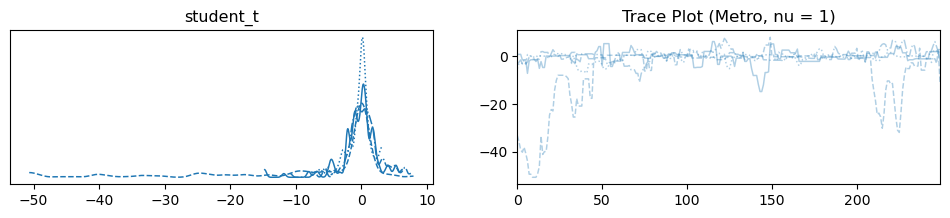

Running HMC with nu = 1


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


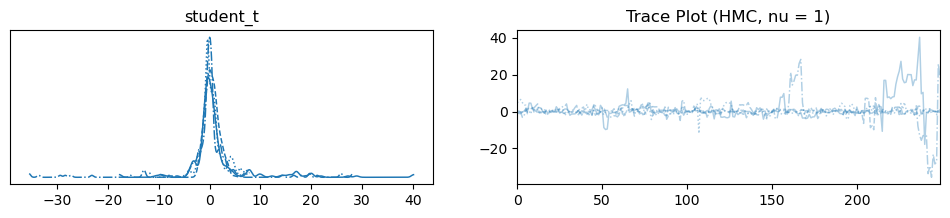

Running DEMetro with nu = 1


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


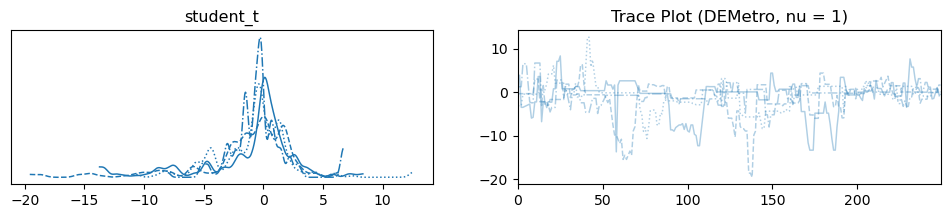

Running Metro with nu = 3


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


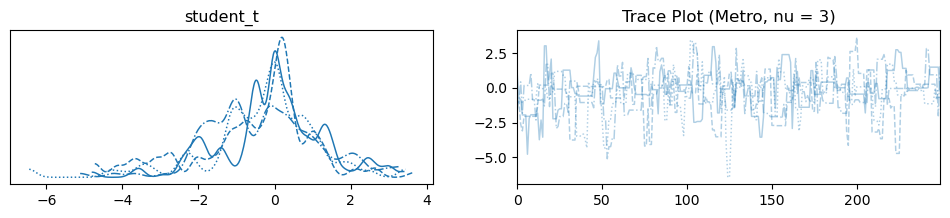

Running HMC with nu = 3


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


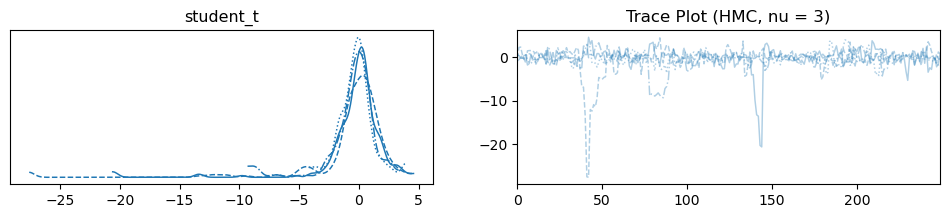

Running DEMetro with nu = 3


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


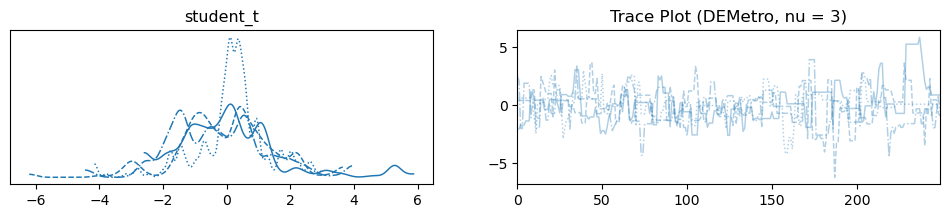


===== All Runs Completed Successfully! =====


===== Config Student_t Completed Successfully! =====


===== Config Laplace_test started! =====


===== Running Laplace_test - Run 1 =====

Running Metro with b = 2


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


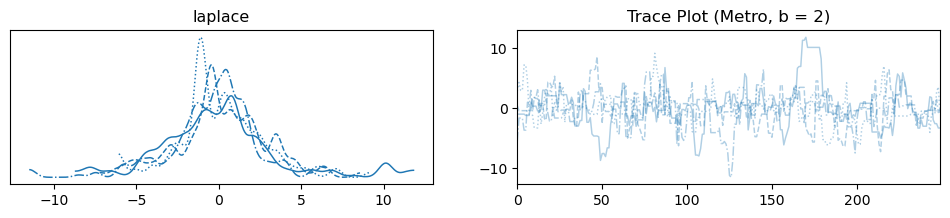

Running HMC with b = 2


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


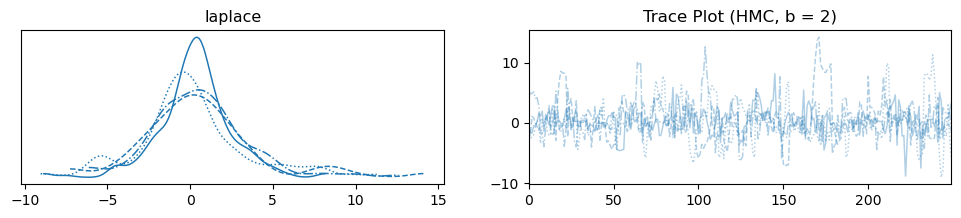

Running DEMetro with b = 2


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


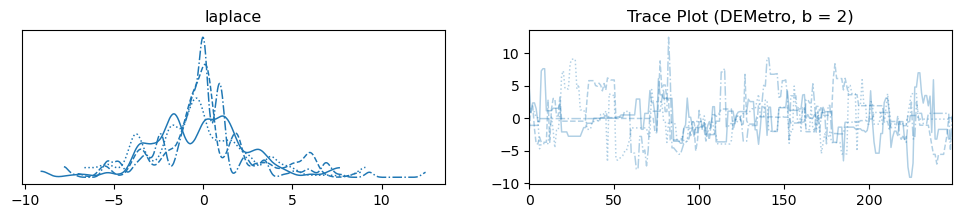

Running Metro with b = 20


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


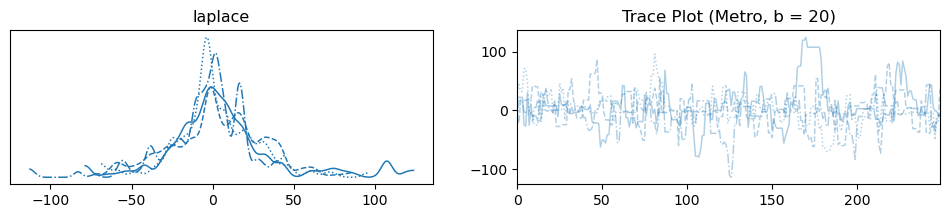

Running HMC with b = 20


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


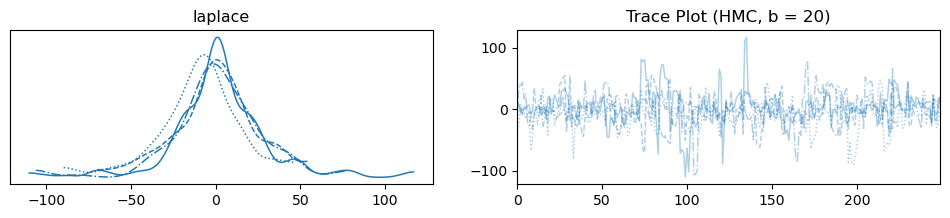

Running DEMetro with b = 20


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


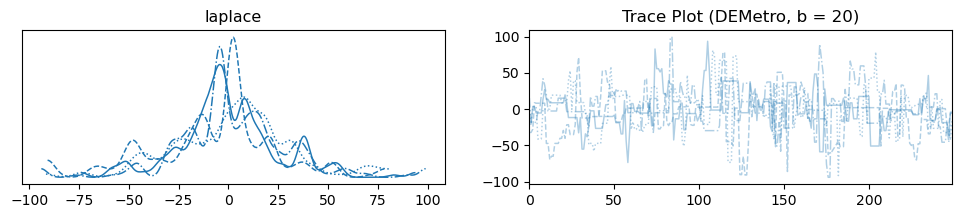


===== All Runs Completed Successfully! =====


===== Config Laplace_test Completed Successfully! =====

All experiments completed successfully!


In [38]:


categories = [unimodal, high_dim_and_correlated, multimodal, difficult_geometries]

# Choose the experiment to run
experiment = categories[0]
experiment_name = "test"

# Define the root directory for all experiments
experiment_root_folder = f"exp_{experiment_name}"

# Check if the folder already exists
if os.path.exists(experiment_root_folder):
    user_input = input(
        f"Folder '{experiment_root_folder}' already exists and will be overwritten.\n"
        "Do you want to continue? (yes/no): "
    ).strip().lower()

    if user_input not in ["yes", "y"]:
        print("Operation aborted. No files were deleted.")
        exit()  # Stop execution
    
    shutil.rmtree(experiment_root_folder)

# Create the experiment directory
os.makedirs(experiment_root_folder)

for config in experiment:
    validate_config(config)

print("All configurations are valid. Starting experiments...")

for config in experiment:
    run_experiment(
    posterior_type=config["posterior_type"],
    config_descr=config["config_descr"],
    runs=config["runs"],
    varying_attribute=config["varying_attribute"],
    varying_values=config["varying_values"],
    init_scheme="varies" if config["varying_attribute"] == "init_scheme" else config.get("init_scheme", None),
    num_samples="varies" if config["varying_attribute"] == "num_samples" else config["num_samples"],
    num_chains="varies" if config["varying_attribute"] == "num_chains" else config["num_chains"],
    base_random_seed=config.get("base_random_seed", None),
    **{k: v for k, v in config.items() if k not in [
        "config_descr", "runs", "varying_attribute", "varying_values", 
        "num_samples", "num_chains", "init_scheme", 
        "base_random_seed", "posterior_type"
    ]}  # Pass remaining keys as posterior_kwargs
)

print("All experiments completed successfully!")


In [ ]:
Test_all_inference_attr = [

    {
        "config_descr": "Samples_test",
        "posterior_type": "bimodal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",    
        "varying_values": [100, 200, 300],
        "mode_means": (3,-3),
        "std_of_modes": (1,1),
        "weights": (1,1)
    },
    
    {
        "config_descr": "Chains_test",
        "posterior_type": "bimodal",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_chains",    
        "varying_values": [4,6,8],
        "mode_means": (3,-3),
        "std_of_modes": (1,1),
        "weights": (1,1)
    }
    #add init scheme test

    #add burn in as well?
    ]


# Can select any of the posterior_type kwargs to vary, e.g., for a normal distribution, mu or sigma can be varied
Test_all_posterior_types = [

    {
        "config_descr": "Normal_test",
        "posterior_type": "normal",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [0, 1, 2],
        "sigma": 1
    },

    {
        "config_descr": "Beta_test",
        "posterior_type": "beta",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "a",
        "varying_values": [0.5,5,1],
        "b": 3,
    },

    {
        "config_descr": "Cauchy_test",
        "posterior_type": "cauchy",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "loc",
        "varying_values": [0, -2, 5],
        "scale": 1,
    },

    {
        "config_descr": "Laplace_test",
        "posterior_type": "laplace",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "b",
        "varying_values": [1, 2, 3, 20],
        "mu": 0,
    },

    {
        "config_descr": "Student_t_test",
        "posterior_type": "student_t",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains":  default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "nu",
        "varying_values": [1, 2, 3],
        "mu": 0,
        "sigma": 1,
    },
    {
        "config_descr": "Skewed_student_t_test",
        "posterior_type": "skewed_student_t",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "a",
        "varying_values": [0.5, 1, 2],
        "b": 1,
        "mu": 0,
        "sigma": 1,
    },

    {
        "config_descr": "Bimodal_test",
        "posterior_type": "bimodal",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mode_means",
        "varying_values": [(0,0), (1,1), (2,2)],
        "std_of_modes": (1,1),
        "weights": (1,1),
    }

]



test_triple_normal = [
    
    {
        "config_descr": "Mixture_test",
        "posterior_type": "mixture",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000, 2000, 8000],
        "component_types": ["normal", "normal", "normal"],
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 10, "sigma": 1}, {"mu": -40, "sigma": 1}],
        "weights": [0.3, 0.5, 0.2]  # Uneven weighting
    }
]


test_normal_and_student_t = [
    
    {   
        "config_descr": "Mixture_test",
        "posterior_type": "mixture",
        "component_types": ["normal", "student_t"],
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [10000],
        "component_params": [{"mu": 0, "sigma": 1}, {"nu": 3, "mu": 5, "sigma": 2}],
        "weights": [0.6, 0.4]
        }
]

test_mvnormal_2d_mixture = [

    {
        "config_descr": "MVNormal_mixture",
        "posterior_type": "mixture",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "component_types": ["mv_normal", "mv_normal", "mv_normal"],
        "component_params": [
                {"mu": [0, 0], "cov": [[1, 0.5], [0.5, 1]]},   # First component
                {"mu": [10, 10], "cov": [[2, 0.3], [0.3, 2]]},  # Second component
                {"mu": [-10, -10], "cov": [[1, -0.2], [-0.2, 1]]}  # Third component
        ],
        "weights": [0.3, 0.4, 0.3]
    }
        
]

test_mvnormal = [
    {
        "config_descr": "MVNormal_test",
        "posterior_type": "mv_normal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "mu": [10, -20],
        #"cov": [[1, 0.5], [0.5, 1]]
        "cov": [[1, 0.95], [0.95, 1]]  # Very strong correlation,
    }
]

test_3d_normal = [

    {
        "config_descr": "MVNormal_test",
        "posterior_type": "mv_normal",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "num_samples",
        "varying_values": [1000],
        "mu":  [-50, 0, 50],
        "cov":  [[1, 0.8, 0.3], [0.8, 1, 0.4], [0.3, 0.4, 1]]  # Works (3D Normal)

    }   

]

#Test_custom = [
#    {
#        "config_descr": "custom_gaussian_mixture",
#        "posterior_type": "custom",
#        "runs": 5,
#        "num_samples": default_num_samples,
#        "num_chains": default_num_chains,
#        "base_random_seed": 42,
#        #"logp_func": my_custom_logp_function,  # Custom function
#        #"priors": {"x": pm.Uniform.dist(lower=-10, upper=10)}
#    }
#]